In [186]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [156]:
class Custom_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        input_data, target_data = self.data[index]
        return input_data, target_data

    def __len__(self):
        return len(self.data)

In [57]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.dropout = nn.Dropout(0.2)
    self.lin1 = nn.Linear(100,64)
    self.lin2 = nn.Linear(64,32)
    self.lin3 = nn.Linear(32,4)

  def forward(self, x):   
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.dropout(x) 
    x = F.sigmoid(self.lin3(x))
    return x

In [176]:
def train(net, dataset, optimizer):
  net.train()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = Variable(target).cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print( "train loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

In [174]:
def test(net, dataset):
  net.eval()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = target.cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
  print("test loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

In [33]:
input = pd.read_table("../data/training/train_data_RNA.txt", sep = " ", header=0)
labels = pd.read_csv("../data/pre_processed/RNA_annotations.csv")
codes, uniques = labels["Sub_trajectory_name"].factorize()
labels["factors"]  = codes

In [159]:
data = []
dist_labels = torch.Tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
for indx, row in input.iterrows():
    data.append([torch.Tensor(row.tolist()), dist_labels[labels[(labels["sample"]==indx)]["factors"].values[0]]])

In [166]:
train_dataset, test_dataset = random_split(Custom_Dataset(data), [0.7, 0.3])

data_loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [177]:
net = Network()
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

train_loss = []
test_loss = []

for epoch in range(100):
  print("epoch:", epoch+1)
  tr_loss = train(net, data_loader_train, optimizer)
  te_loss = test(net, data_loader_test)
  train_loss.append(tr_loss)
  test_loss.append(te_loss)

np.savez('Learning_Curves.npz', train_loss=train_loss, test_loss=test_loss)
torch.save(net, 'saved_net.py')

epoch: 1
train loss: 0.043590808864925674
test loss: 0.017510118447928314
epoch: 2
train loss: 0.017305981525437726
test loss: 0.014038023063111138
epoch: 3
train loss: 0.015189666818719987
test loss: 0.013912021464021401
epoch: 4
train loss: 0.014361588545756027
test loss: 0.015258655316812666
epoch: 5
train loss: 0.014011653072324303
test loss: 0.012161988678977179
epoch: 6
train loss: 0.01298167238745391
test loss: 0.012593558427136014
epoch: 7
train loss: 0.012788412779248519
test loss: 0.011151258218985664
epoch: 8
train loss: 0.012201004883507635
test loss: 0.011056159043028594
epoch: 9
train loss: 0.012005777722936326
test loss: 0.011704656816473692
epoch: 10
train loss: 0.011652408549793825
test loss: 0.011074490849318396
epoch: 11
train loss: 0.011356806529573302
test loss: 0.00999700709681599
epoch: 12
train loss: 0.011158883685350387
test loss: 0.010255515017453332
epoch: 13
train loss: 0.010740224096332242
test loss: 0.009291653475450318
epoch: 14
train loss: 0.010290348348

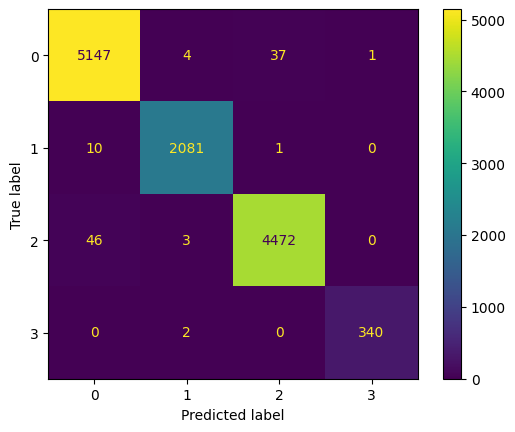

In [188]:
net.cpu()

X = [i for i,j in test_dataset]
pred = [net(x) for x in X]
y_true = [np.argmax(j) for i,j in test_dataset]
y_pred = [np.argmax(i.detach().numpy()) for i in pred]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()